(ch_pyTrends)=
# Time series analysis

## Packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from datetime import datetime
from astropy.convolution import convolve, Gaussian1DKernel
from scipy.optimize import curve_fit
from scipy.stats import theilslopes, kendalltau
from sklearn import linear_model, metrics
from matplotlib import pyplot as plt

gdal.UseExceptions()

## Dates and time

Time series analyses require us to deal with dates and times. The `datetime` submodule from the `datetime` module provides us with functions to create datetime objects and to convert between different datetime formats and units. When reading raster and vector datasets, dates and times might be coded as strings. In some raster formats, like NetCDF, datetimes are directly readable, while other formats, like GeoTIFFs, require placing the datetimes in the band/layer names.

In the example below, we convert the dates stored as strings to datetime objects using the `strptime()` function. The function takes the string as argument as well as a string pattern (here: '%Y%m%d') that defines how the date is coded as string. We use a list comprehension to apply `strptime()` to every element in `bandNames`.

In [2]:
from datetime import datetime

bandNames = ['20180201', '20180408', '20180513', '20180616', '20180823']

# Convert dates stored as strings to datetime objects             
tstamps = [datetime.strptime(x, '%Y%m%d') for x in bandNames]
print(tstamps)

[datetime.datetime(2018, 2, 1, 0, 0), datetime.datetime(2018, 4, 8, 0, 0), datetime.datetime(2018, 5, 13, 0, 0), datetime.datetime(2018, 6, 16, 0, 0), datetime.datetime(2018, 8, 23, 0, 0)]


For time series analyses, we need a single time axis that can be expressed as numerical values. One numerical presentation of time across years is the **decimal date** representation of time, which represents the day of years as fractional values between years. A simple (not accurate) way to calculate decimal years is as follows:

In [3]:
decimal_date = [x.timetuple().tm_year + x.timetuple().tm_yday/datetime(x.timetuple().tm_year, 12, 31).timetuple().tm_yday for x in tstamps]
print(decimal_date)

[2018.0876712328768, 2018.268493150685, 2018.3643835616438, 2018.4575342465753, 2018.6438356164383]


Another popular way to express time on a numerical scale is **Julian day**, which is a continuous count of days from the beginning of the Julian period. However, any other starting day may be picked too.

In [4]:
from astropy.time import Time

julday = [Time(x).jd for x in tstamps]
print(julday)

[2458150.5, 2458216.5, 2458251.5, 2458285.5, 2458353.5]


If you are working within the timeframe of a single year, then **day of year** (`doy`) is also an option:

In [5]:
doy = [x.timetuple().tm_yday for x in tstamps]
print(doy)

[32, 98, 133, 167, 235]


## Time series decomposition

Time series decomposition is a powerful statistical technique to break down a time series into its fundamental components:

* The **trend component** represents the long-term trajectory or direction of the time series, capturing sustained and systematic changes over time, such as growth or decline. The trend can manifest as linear or nonlinear, depending on the data's behavior.

* The **seasonal component** identifies regular, predictable cycles within the data, typically occurring at fixed intervals—such as daily, weekly, monthly, or annually. These cycles often arise from recurring external factors, including weather patterns, holidays, or economic cycles.

* The **residual component**, also referred to as the error or noise, encompasses the random, unpredictable fluctuations in the data that cannot be explained by the trend or seasonality. This component captures the irregular variations and anomalies that remain after the trend and seasonal patterns have been accounted for.

## Harmonic regression

Harmonic regression is a statistical method used to model periodic or cyclical patterns in time series data. It is particularly useful when the data exhibits regular, repetitive cycles, such as seasonal variations, which can be effectively captured using sine and cosine functions. In essence, harmonic regression fits a combination of sinusoidal waves (harmonics) to the data, allowing for the modeling of complex cyclical trends. The traditional harmonic regression assumes the periodic components remain constant over time.

$$\hat{y}(t) = \alpha_0 + \alpha_1 t + \sum_{n=1}^{N}\left( \beta_n cos(2\pi n \frac{t}{T}) + \gamma_n  sin(2\pi n \frac{t}{T}) \right)$$

where $\alpha$, $\beta$, and $\gamma$ are the parameters, $t$ is time, $T$ is the period of the seasonality ($T=1$ if $t$ is years, $T=12$ if $t$ is months). $n$ is the order of the harmonic function. For example, a first-order harmonic model may look like this ($n$=1). We rename all parameters as $\beta$'s out of convenience:

$$\hat{y}(t) = \beta_0 + \beta_1 t + \beta_2 cos(2\pi \frac{t}{T}) + \beta_3  sin(2\pi \frac{t}{T})$$

A second-order harmonic model may look like this:

$$\hat{y}(t) = \beta_0 + \beta_1 t + \beta_2 cos(2\pi \frac{t}{T}) + \beta_3  sin(2\pi \frac{t}{T}) + \beta_4 cos(4\pi \frac{t}{T}) + \beta_5  sin(4\pi \frac{t}{T})$$

### Mauna Loa

Let's take a popular example: the rising $CO_2$ concentration measured at Mauna Loa Observatory since the late 1950's (Source: https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html). The data set contains the `decimal_date`, the  $CO_2$ concentration as the daily `average` and the `interpolated` values treating missing observations, and the estimated `trend`.

In [6]:
co2 = pd.read_csv("figs/co2_mm_mlo.txt", comment='#', delim_whitespace=True,
                  names=["year", "month", "decimal_date", "average", "interpolated", "trend", "days"],
                  na_values=[-99.99, -1])
co2.head()

year  month  decimal_date  average  interpolated   trend  days
0  1958      3      1958.208   315.71        315.71  314.62   NaN
1  1958      4      1958.292   317.45        317.45  315.29   NaN
2  1958      5      1958.375   317.50        317.50  314.71   NaN
3  1958      6      1958.458      NaN        317.10  314.85   NaN
4  1958      7      1958.542   315.86        315.86  314.98   NaN

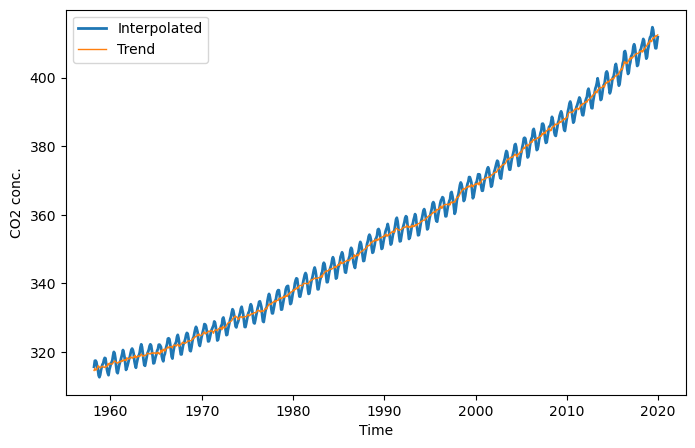

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(co2.decimal_date, co2.interpolated, '-', lw=2, label="Interpolated")
plt.plot(co2.decimal_date, co2.trend, '-', lw=1, label="Trend")
plt.xlabel("Time"); plt.ylabel("CO2 conc."); plt.legend(loc="best");

The $CO_2$ concentration follows an exponential increase over the years. We can fit this exponential increase with a linear model by including a quadratic term of time $t$:

$\hat{y}= \beta_0 + \beta_1t + \beta_2t^2 + \epsilon$

where $t$ is time (the x variable), $\hat{y}$ is the estimated $\mathbf{CO_2}$, and $\epsilon$ is the residual error.

### Linear model

There are several solutions in python to fit linear models, e.g., `numpy.linalg.lstsq()` and `scipy.stats`. Here, we will use the familiar `scikit-learn` module. First, we instantiate a linear regression model.

In [8]:
ltrend = linear_model.LinearRegression()


Second, we prepare the response variable $y$ and the predictor matrix $X$, which contains the two date variables $t$ and $t^2$.

In [9]:
t = co2.decimal_date
y = co2.interpolated

X = np.array([t, t**2]).T # transpose
X.shape, y.shape

((742, 2), (742,))

Now lets fit the model and apply it to $X$ to obtain the fitted observations.

In [10]:
ltrend.fit(X, y)
y_fit = ltrend.predict(X)

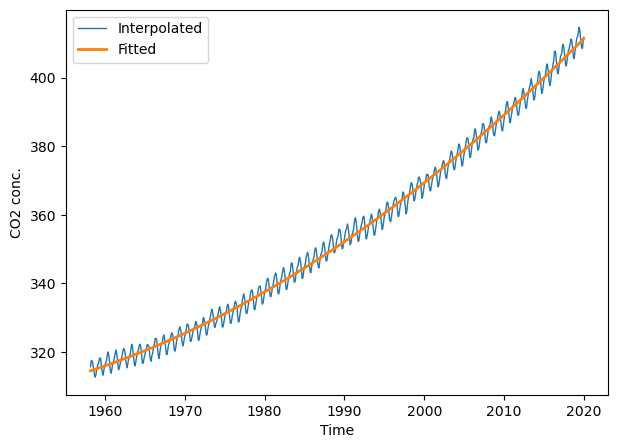

In [11]:
plt.figure(figsize=(7, 5))
plt.plot(t, co2.interpolated, '-', lw=1, label="Interpolated")
plt.plot(t, y_fit, '-', lw=2, label="Fitted")
plt.xlabel("Time"); plt.ylabel("CO2 conc."); plt.legend(loc="best");

### First-order harmonic model

So far, we've ignored the seasonal component in the $CO_2$ time series. To accomodate for the seasonality, we might fit a first-order harmonic model and include a quadratic term for the trend:

$$\hat{y}(t) = \beta_0 + \beta_1 t + \beta_2 {t}^2 + \beta_3 cos(2\pi \frac{t}{T}) + \beta_4  sin(2\pi \frac{t}{T})$$

In [12]:
period = 1. # when t in units of years / period = 365 when t in units of days
t = co2.decimal_date
X = np.array([t, 
              t * t,
              np.cos(2.0 * np.pi * (t / period)),
              np.sin(2.0 * np.pi * (t / period))]).T
y = co2.interpolated
X.shape, y.shape

((742, 4), (742,))

In [13]:
lharm = linear_model.LinearRegression()
lharm.fit(X, y)

LinearRegression()

In [14]:
y_fit_harmonic = lharm.predict(X)
metrics.r2_score(co2.interpolated, y_fit_harmonic)

0.9988600549056532

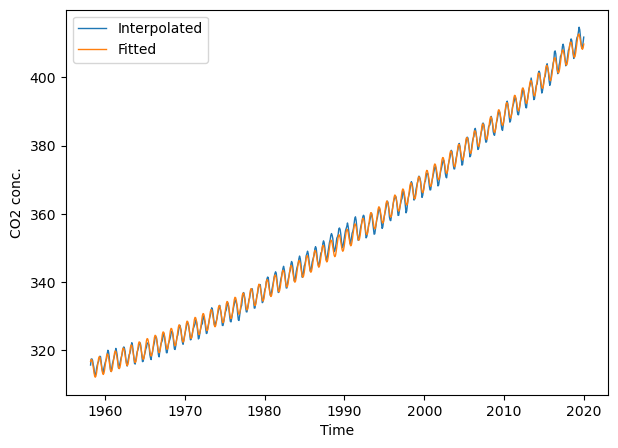

In [15]:
plt.figure(figsize=(7, 5))
# plt.xlim(2000, 2022); plt.ylim(360, 420) # limit x- and y-axis range
plt.plot(t, co2.interpolated, '-', lw=1, label="Interpolated")
plt.plot(t, y_fit_harmonic, '-', lw=1, label="Fitted")
plt.xlabel("Time"); plt.ylabel("CO2 conc."); plt.legend(loc="best");

We can also extract the parameters for the linear trend ($t$ and $t^2$), i.e., the first and second coefficient returned by the linear model. Together with the intercept, we have everything we need to fit and plot the trend line.

In [16]:
lharm.intercept_

47970.31758050327

In [17]:
lharm.coef_

array([-4.94500477e+01,  1.28247861e-02, -1.00714213e+00,  2.63843950e+00])

In [18]:
def fit_trend(t, a0, a1, a2):
    result = a0 + a1*t + a2*t*t
    return result

fitted_trend = fit_trend(t, lharm.intercept_, lharm.coef_[0], 
                         lharm.coef_[1])

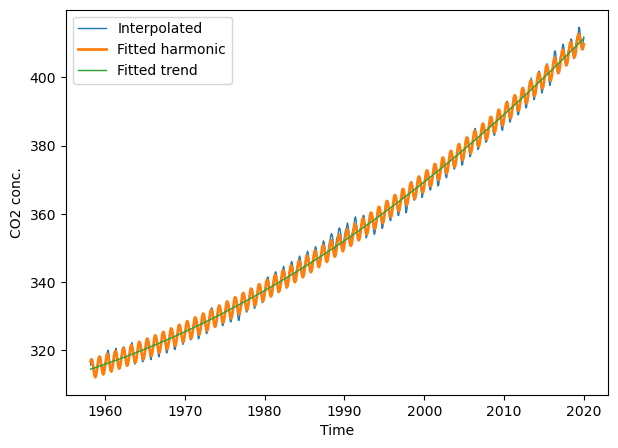

In [19]:
plt.figure(figsize=(7, 5))
# plt.xlim(2000, 2022); plt.ylim(360, 420) # limit x- and y-axis range
plt.plot(t, co2.interpolated, '-', lw=1, label="Interpolated")
plt.plot(t, y_fit_harmonic, '-', lw=2, label="Fitted harmonic")
plt.plot(t, fitted_trend, '-', lw=1, label="Fitted trend")
plt.xlabel("Time"); plt.ylabel("CO2 conc."); plt.legend(loc="best");

## Fitting non-linear functions

Fitting linear functions is convenient in several ways since we can find an analytical solution to directly estimate the coefficients. However, non-linear models usually require iterative optimization techniques such as Levenberg-Marquardt algorithm or Gradient descent methods. This means, non-linear techniques are less stable - there are situations where they may not converge to a solution. In Python, [`scipy.optimize.curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) provides a way to do non-linear least squares fitting of a function. Usually, we apply this technique to non-linear functions, e.g., double logistic. Here, we test it to the harmonic model (which usually is better fit with a linear solver - but let's do it for the sake of comparison). 

To fit a non-linear function, we first have to create a function that defines the mathematical function that we want to fit. The function `fun_harmonic()` defines the harmonic function based on time $t$ and the parameters $a1$, $a2$, $a3$, and $a4$.

In [20]:
def fun_harmonic(t, a0, a1, a2, a3, a4, period=1.):
    result = a0 + a1*t + a2*t*t + \
             a3 * np.cos(2 * np.pi * (t / period)) + \
             a4 * np.sin(2 * np.pi * (t / period))
    return result

We can test the function by plotting it. To do that we feed it with a 1D array for time `x` and some parameters `params`. Note, instead of entering every parameter individually into the function arguments, we can unpack the `params` array using the `*` sign. If you are unsure what that means, then read *Packing and unpacking* in chapter [Think (more) python](ch_thinkPython).

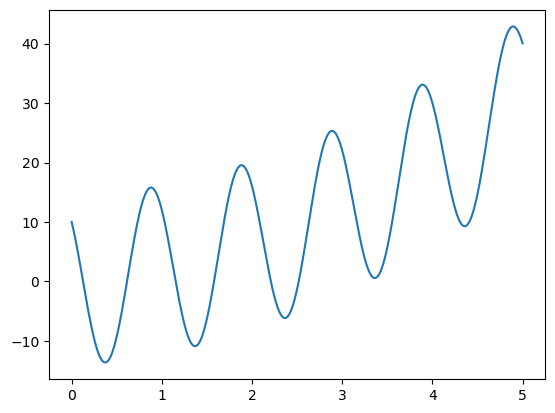

In [21]:
params = [0, 1, 1, 10,  -10]
x = np.arange(0, 5, 0.001)
y = fun_harmonic(x, *params)

plt.plot(x, y, '-');


Again, `fun_harmonic` simply defines the mathematical behavior of the harmonic function. What we now want to do, is to estimate the parameters of a harmonic function that best fits our data points. In the example below, the data points are described by `x` (time) and `y` ($CO_2$). We can use `curve_fit` to do the fitting. The function `curve_fit` requires several arguments: 1) the function to fit, 2) and x array, 3) a y array, and 4) an initial guess for the parameters (`param_start`).

In [22]:
x = co2.decimal_date
y = co2.interpolated
param_start = np.ones(5) # Initial guess for the parameters

p_opt, p_cov = curve_fit(fun_harmonic, x, y, p0=param_start)
p_opt


array([ 4.79703181e+04, -4.94500482e+01,  1.28247863e-02, -1.00714208e+00,
        2.63843943e+00])

We can now describe the harmonic function based on the fitted parameters `p_opt`.

In [23]:
y_fit = fun_harmonic(x, *p_opt)

Let's visualize the original CO2 `y`and the fitted CO2 concentration `y_fit`. 

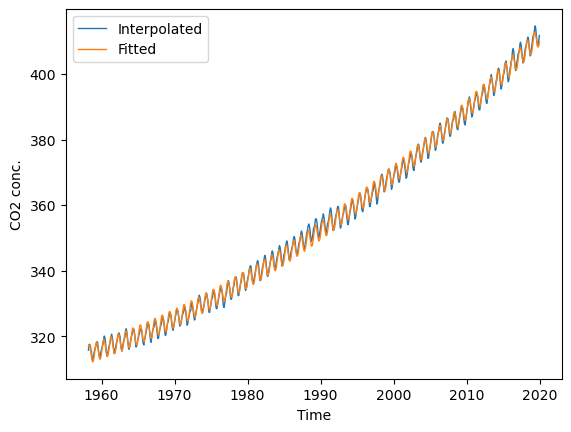

In [24]:
plt.plot(x, y, '-', lw=1, label="Interpolated")
plt.plot(x, y_fit, '-', lw=1, label="Fitted")
plt.xlabel("Time"); plt.ylabel("CO2 conc."); plt.legend(loc="best");

## NDVI time series

The example below reads an NDVI time series raster stack, masks out nodata pixels and rescales NDVI back to decimal numbers. The raster has 1200 x 1200 rows and columns and 67 time steps.

In [25]:
src_ds = gdal.Open("../../data/vi_timeseries/ndvi_X0070_Y0040_subset_2018.tif")

ndvi = src_ds.ReadAsArray()
nodata = ndvi == -32767
ndvi = ndvi / 10000.0
ndvi[nodata] = np.nan

ndvi.shape

(67, 1200, 1200)

Let's also extract the band names to get at the dates corresponding to each layer,

In [26]:
bandNames = [src_ds.GetRasterBand(i).GetDescription() for i in range(1, src_ds.RasterCount + 1)]
src_ds = None

print(bandNames[ :8])


['20180201_SEN2A', '20180208_SEN2A', '20180213_SEN2B', '20180216_SEN2B', '20180223_SEN2B', '20180226_SEN2B', '20180228_SEN2A', '20180303_SEN2A']


...and convert them to datetime objects and day of year.

In [27]:
tstamps = np.array([datetime.strptime(x[0:8], '%Y%m%d') for x in bandNames])

doy = np.array([x.timetuple().tm_yday for x in tstamps])
print(doy[:12])

[32 39 44 47 54 57 59 62 77 84 92 97]


## Smoothing and interpolation

It can be beneficial or even necessary to fill data gaps and/or smooth high frequency noise prior to extracting time series information. The SciPy User Guide provides information on selected [interpolation methods](https://docs.scipy.org/doc/scipy/tutorial/interpolate/1D.html#tutorial-interpolate-1dsection) including linear interpolation, polynomials, and splines. To simply fill-in the missing values, we are going to use a simple piecewise linear interpolation. First, I am demonstrating the interpolation using a single pixel. Later, we apply the interpolation to the entire image.

In [28]:
pixel_vi = ndvi[:, 300, 120] # select a single pixel for demonstration
pixel_vi[ :8]

array([   nan,    nan, 0.4756, 0.4336, 0.4466,    nan,    nan, 0.3858],
      dtype=float32)

I am wrapping the interpolation code into a function (`piecewise_interpolation`) that takes the day of years (`doy`) and the NDVI values as arguments. This way, we can later apply the interpolation to the entire NDVI image time series.

In [29]:
def piecewise_interpolation(doy, vi):

    t = doy[np.isnan(vi) != True] # select t with valid NDVI
    y = vi[np.isnan(vi) != True]  # select valid NDVI values

    # We can interpolate to any time intervals.
    # Here we interpolate to the original day of years (doy)
    return np.interp(doy, t, y)

pixel_intp = piecewise_interpolation(doy, pixel_vi)
pixel_intp[ :8]

array([0.4756    , 0.4756    , 0.4756    , 0.43360001, 0.44659999,
       0.4238    , 0.4086    , 0.3858    ])

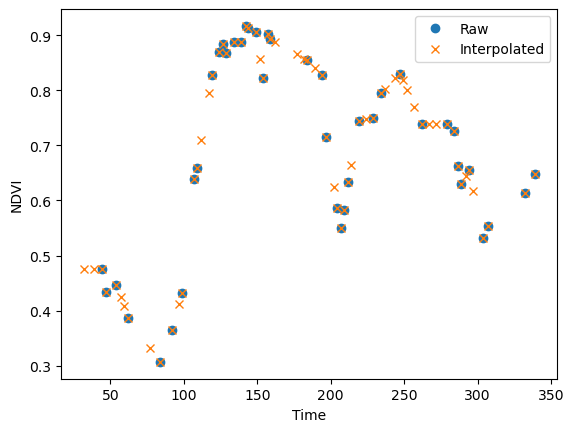

In [30]:
plt.plot(doy, pixel_vi, 'o', label="Raw")
plt.plot(doy, pixel_intp, 'x', label="Interpolated")
plt.xlabel("Time"); plt.ylabel("NDVI"); plt.legend(loc="best"); plt.show(); 

### Convolution filters

Convolution filters are useful for smoothing time series. We've introduced SciPy's convolution filters in chapter Map Algebra. However, these convolution filters do not deal with missing values. Alternatively, the `astropy` library provides a 1D-convolution that ignores missing values. In the example below, we use astropy's `Gaussian1DKernel` function to create a gaussian kernel, and the astropy's `convolution` function to apply the kernel to the NDVI raster.

In [31]:
kernel = Gaussian1DKernel(stddev=1.5)
kernel = np.reshape(kernel, (kernel.shape[0], 1, 1)) # reshape to match the resolution of the raster
kernel.shape

(13, 1, 1)

In [32]:
ndvi_conv = convolve(ndvi, kernel, boundary='fill', fill_value=np.nan, normalize_kernel=False)

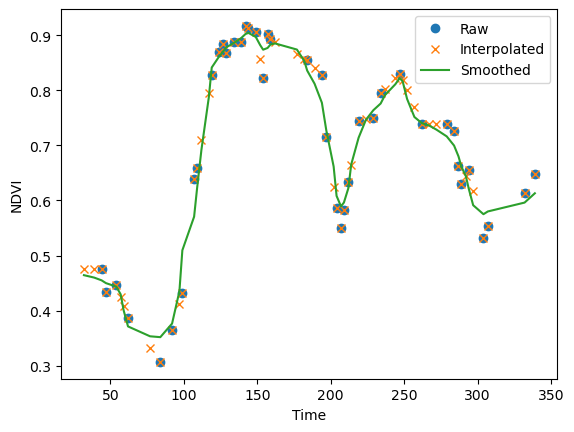

In [33]:
pixel_conv = ndvi_conv[:, 300, 120]

plt.plot(doy, pixel_vi, 'o', label="Raw")
plt.plot(doy, pixel_intp, 'x', label="Interpolated")
plt.plot(doy, pixel_conv, label="Smoothed")
plt.xlabel("Time"); plt.ylabel("NDVI"); plt.legend(loc="best"); plt.show(); 

## Apply to arrays

We can use numpy's `apply_along_axis()` to apply existing or user-defined functions to a specific array dimension. In this case, we want to apply our user-defined interpolation function to the NDVI time series. The `apply_along_axis()` function takes in the name of a function as argument. However, our function has two arguments, and passing them to `apply_along_axis()` is not trivial. Since the `vi` input changes with every pixel but not the `doy` we can remove the `doy` from the function call. The example below works, even though `doy` is not defined in the function. The good news (or bad), Python can access variables that are defined in higher environments, i.e., environments which scope include the function. In our case, we defined `doy` earlier when reading the NDVI image. 


In [34]:
def piecewise_interpolation_single_argument(vi):

    t = doy[np.isnan(vi) != True] # select t with valid NDVI
    y = vi[np.isnan(vi) != True]  # select valid NDVI values

    # We can interpolate to any time intervals.
    # Here we interpolate to the original day of years (doy)
    return np.interp(doy, t, y)

ndvi_intp = np.apply_along_axis(piecewise_interpolation_single_argument, axis=0, arr=ndvi)

Relying on Python's hierarchical scope can be tricking, especially if you are working with parallel processing. So, this is a place where Python's [**lambda functions**](https://www.w3schools.com/python/python_lambda.asp) come in handy. Lambda functions allow you to define a Python function using one line of code. In the code below, `x` will be the NDVI values for each pixel while `doy` was defined earlier.

In [35]:
ndvi_intp = np.apply_along_axis(lambda x : piecewise_interpolation(doy, x), 0, ndvi)

Let's visually compare the original NDVI image against the interpolated and smoothed NDVI image. The figure below shows a time slice from mid February were data gaps are relatively wide. While the convolution filter did a good job smoothing the time series, it still contains data gaps were the kernel was too small. We could increase the size of the kernel, but than sharp increases or decreases in NDVI would be smoothed out. Therefore, studies often use multiple convolution filters (ensembles) of varying width to accommodate varying data gaps and NDVI dynamics.

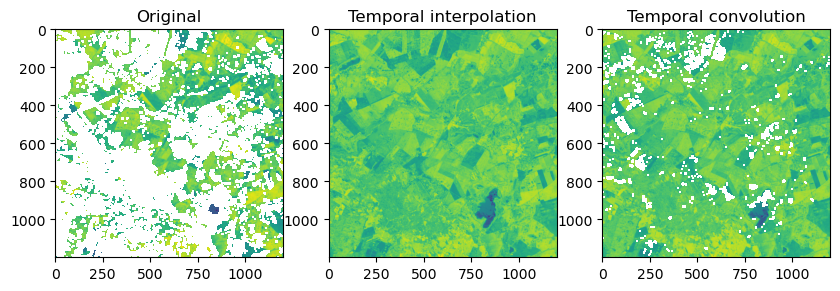

In [36]:
f, ax = plt.subplots(1,3, figsize=(10, 6))
ax[0].imshow(ndvi[3, :, :]); ax[0].set_title("Original");
ax[1].imshow(ndvi_intp[3, :, :]); ax[1].set_title("Temporal interpolation");
ax[2].imshow(ndvi_conv[3, :, :]); ax[2].set_title("Temporal convolution");


## Non-Parametric Trend Analysis
### Sen's slope

In non-parametric statistics, the Theil–Sen estimator is a method for robustly fitting a line to sample points in the plane (simple linear regression) by choosing the median of the slopes of all lines through pairs of points ([wikipedia](https://en.wikipedia.org/wiki/Theil–Sen_estimator)). The estimator is insensitive to outliers and can be more accurate than non-robust simple linear regression (least squares) for skewed and heteroskedastic data. As a result the Sen slope has been very popular for estimating linar trends. Sen's slope is often combined with the non-parametric Mann-Kendall test for the presence of an increasing or decreasing trend.

In [37]:
slope, intercept, low_slope, high_slope = theilslopes(y, t)

### Mann-Kendall test

Sen's slope is often combined with the non-parametric **Mann-Kendall** test for the presence of an increasing or decreasing trend. Kendall’s tau is a measure of the correspondence between two rankings. Values close to 1 indicate strong agreement, and values close to -1 indicate strong disagreement. 

In [38]:
tau, p_value = kendalltau(t, y)